In [1]:
# https://docs.lightkurve.org/tutorials/3-science-examples/periodograms-creating-periodograms.html

# Creating periodograms and identifying significant peaks

## Learning Goals

By the end of this tutorial, you will:

- Understand the definition and utility of the frequency domain.
- Understand the concept of a periodogram.
- Be able to create a periodogram from *Kepler* data using Lightkurve.
- Be able to interpret a periodogram.

## Introduction

The [*Kepler*](https://www.nasa.gov/mission_pages/kepler/main/index.html) and [*TESS*](https://tess.mit.edu/) telescopes observe stars for long periods of time, from just under a month to four years. By doing so they observe how the brightnesses of stars change over time.

Some signals that appear in these time series will form repeating patterns. In other words, they oscillate. These oscillations are better studied in frequency space, through the means of a *periodogram*. This tutorial provides an explanation of what a periodogram is, and how you can use Lightkurve's tools to study a *Kepler* observation in the frequency domain.

Stars of all shapes, sizes, and ages experience changes in brightness. This variability repeats over time, forming oscillation signals that we can observe in *Kepler* data. 

Stellar brightness variability can have various sources. Some stars will vary in brightness due to star spots rotating in and out of view. Others pulsate, shrinking and expanding due to waves forming inside of the star. And still others may vary in brightness due to interaction with a nearby companion. By understanding the stellar variability, we can learn a lot about the conditions on, within, and around the star itself.

Because stellar variablity produces oscillating signals, and *Kepler* data can span up to four years, it is often cumbersome to study these oscillations in the time domain. Instead, we can study them in the frequency domain, where signals are separated into bins of frequency, and strong repeating patterns are more readily discerned.


## Imports
This tutorial requires **[Lightkurve](https://docs.lightkurve.org)**, which in turn uses **[matplotlib](https://matplotlib.org/stable/index.html)** for plotting.

In [2]:
import lightkurve as lk
%matplotlib inline

## 1. The Frequency Domain

To understand the frequency domain, we must first understand a little about the concept of a [Fourier Transform (FT)](https://en.wikipedia.org/wiki/Fourier_transform), the mathematical transformation we can use to translate time-domain data into the frequency domain.

If we have a function of time $x(t)$, such as the brightness of a star, the FT of this function, $X(\nu)$, is given as 

$$X(\nu) = \int^{+\infty}_{-\infty}x(t)e^{-2\pi i\nu t}\rm{d}t\, ,$$

where $t$ is time, $i$ is the imaginary unit, and $\nu$ is frequency. This equation looks like a bit of a handful, so let's try to break it down:

A Fourier Transform...

- for a frequency $\nu$,
- $e^{-2\pi i \nu t}$: takes a cosine and a sine of that frequency*, and
-  $x(t) e^{-2\pi i \nu t}$: multiplies it with the function at time $t$, and
-  $\int^{+\infty}_{-\infty} x(t) e^{-2\pi i \nu t} \rm{d}t$ : integrates over the full range of time:
- The result of this is the value of the Fourier Transform at that frequency: $X(\nu)$. 

*through [Euler's formula](https://en.wikipedia.org/wiki/Euler%27s_formula).

For example, if you had a function that was a sine wave with a frequency of $5\, \rm Hz$, $X(5\, \rm Hz)$ would be large. But if you had a sine wave with a vastly different frequency (like $100\, \rm Hz$), $X(5\, \rm Hz)$ would be small. And $X(100\, \rm Hz)$ would be large!

In short, the FT of a function shows us the frequencies of periodic signals. This is incredibly useful when studying stars, which exhibit all kinds of variability due to rotation, activity, granulation, and sound waves under their surface. A FT lets us extract the oscillation frequencies of these events more clearly.

## 2. Creating a Periodogram from *Kepler* Data

If we want to study *Kepler* data in the frequency domain, there are a couple of approximations we need to make. Mainly, we need to account for the fact that our data is *not* a continuous function, but a discrete set of observations. The required operation to convert a discrete function to the frequency domain is called a Discrete Fourier Transform (DFT).

One of the methods people use to estimate the DFT of a light curve is the *Lomb-Scargle periodogram*. Without delving into the details here, a periodogram is an estimation of what the FT of the data would look like were it a continuous function. You can find a thorough explanation of both the Fourier Transform as well as the Lomb-Scargle periodogram in [Vanderplas (2017)](https://arxiv.org/pdf/1703.09824.pdf).

Lightkurve's built-in functions use the [Astropy Lomb-Scargle](https://docs.astropy.org/en/stable/timeseries/lombscargle.html) implementation. Let's use it below to have a look at a periodogram of an eclipsing binary star, KIC 10264202.

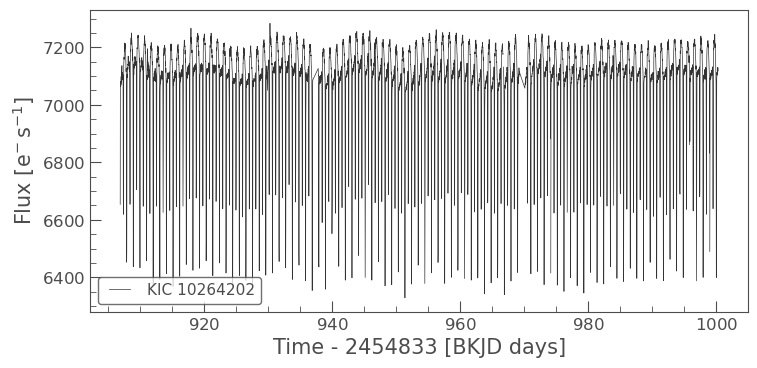

In [3]:
lc = lk.search_lightcurve('KIC 10264202', author="Kepler", quarter=10).download()
lc.plot();

 An eclipsing binary is a pair of stars which orbit one another in such a way that they periodically eclipse each other with respect to us, the observers. The eclipse produces a repeating pattern of two "dips" per orbit, creating a rich pattern of ups and downs in the light curve. These stars [show up frequently](https://iopscience.iop.org/article/10.3847/0004-6256/151/3/68) in *Kepler* observations. From looking at this light curve, we might expect two strong peaks in the periodogram, namely:
- at the frequency of the very long period (low frequency), variability visible with peaks around $7100\, e^-s^{-1}$
- at the frequency of the very short period (high frequency), spikes are visible peaking near $7200\, e^-s^{-1}$

The "spikes" here are the eclipsing binary pair components transiting in front of one another, and it is this signal that we should expect to have the largest peak in the periodogram, because it has the largest amplitude in the time domain.

We can create a periodogram of this light curve using the [to_periodogram()](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.to_periodogram.html?highlight=to_periodogram) function. We first normalize the flux units to parts per million (`ppm`), which gives a more intuitive impression of the relative power of these oscillations.

In [4]:
pg = lc.normalize(unit='ppm').to_periodogram()
pg

LombScarglePeriodogram(ID: KIC 10264202)

Here, the object `pg` is a [LombScarglePeriodogram](https://docs.lightkurve.org/reference/api/lightkurve.periodogram.LombScarglePeriodogram.from_lightcurve.html). This object contains all of the properties of the [Periodogram](https://docs.lightkurve.org/reference/api/lightkurve.periodogram.Periodogram.html) class, as well as some features unique to Lomb-Scargle periodograms, which will be discussed in the next tutorial.

As with a [LightCurve](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html#lightkurve.LightCurve) or [TargetPixelFile](https://docs.lightkurve.org/reference/targetpixelfile.html?highlight=targetpixelfil) object, we can plot the periodogram using the [plot()](https://docs.lightkurve.org/reference/api/lightkurve.periodogram.Periodogram.plot.html?highlight=plot#lightkurve.periodogram.Periodogram.plot) function.

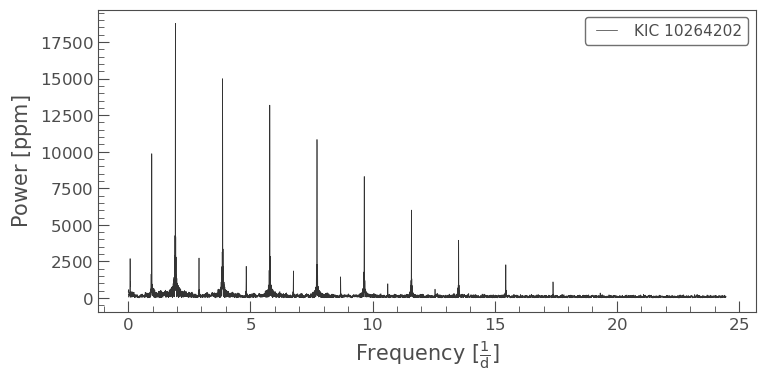

In [5]:
pg.plot();

While at first glance it may look like there are lots of different signals, the repeating, evenly spaced peaks in this instance are likely *alias harmonics* of the true oscillation frequency. Harmonics are integer multiples of the oscillation frequency. They occur when a light curve is finite in duration or contains gaps, in which case it is common for a DFT to identify integer multiples as additional candidate signals. For example, an eclipse with a period of 10 days can easily be mistaken for an eclipse with a period of 20 days, in particular when the data contains gaps near the transit times. The [Vanderplas (2017)](https://arxiv.org/pdf/1703.09824.pdf) paper provides a detailed explanation of this phenomenon.

Repeating harmonic peaks and aliasing is a common issue in frequency-domain analysis, particularly when the time-domain signal isn't exactly shaped like a sine wave, as is the case here.  All of the harmonic peaks are of the same origin — the period of the star — but only one of them represents the truth. In what follows below, we will demonstrate a trial and error method to identify the true peak.

**Note**: As we will see below, the frequencies on display here correspond to the short period (high frequency) "spikes" we identified in the time domain. The long period (low frequency) oscillation we identified is at much lower frequencies. We can see this more clearly if we plot the x-axis in log space.

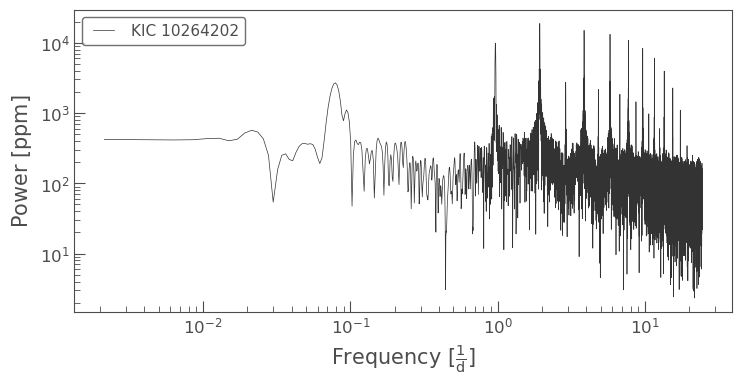

In [6]:
pg.plot(scale='log');

The low-frequency peak can be seen around $0.09$ cycles per day.

## 3. Using a *Kepler* Periodogram to Identify a Significant Period

We now have a decent grasp on how the periodogram represents the repeating signals in the light curve of our eclipsing binary target. If we wanted to measure what the binary pair's orbital period is, our first port of call would be to look at the period of the highest peak. A [Periodogram](https://docs.lightkurve.org/reference/api/lightkurve.periodogram.Periodogram.html?highlight=periodogram#lightkurve.periodogram.Periodogram) object will store a number of details about the periodogram, which can be accessed through the [show_properties()](https://docs.lightkurve.org/reference/api/lightkurve.periodogram.Periodogram.show_properties.html?highlight=show_properties) method.

In [7]:
pg.show_properties()

lightkurve.Periodogram properties:
      Attribute         Description   Units
---------------------- -------------- -----
                nterms              1      
              targetid       10264202      
          default_view      frequency      
                 label   KIC 10264202      
             ls_method           fast      
frequency_at_max_power         1.9314 1 / d
             max_power     18774.4969   ppm
               nyquist        24.4695 1 / d
   period_at_max_power         0.5177     d
             frequency array (11427,) 1 / d
                period array (11427,)     d
                 power array (11427,)   ppm
                  meta <class 'dict'>      


Besides the `frequency` and `power` arrays we've seen plotted, there's also some other important information here. The `period` array is the inverse of the `frequency` array and the `ls_method` specifies the [Astropy Lomb-Scargle](https://docs.astropy.org/en/stable/timeseries/lombscargle.html) method used ([see more on periodogram algorithms here](https://docs.astropy.org/en/stable/timeseries/lombscargle.html#periodogram-algorithms)). The `nyquist` parameter is maximum oscillation frequency that can be reliably determined from a time series signal. It is defined as $\nu_{\rm nyq} = \frac{1}{2\Delta t}$ where $\Delta t$ is the observing cadence, and its use will be explored in the companion tutorials.

The information we're particularly interested in here is the [period_at_max_power](https://docs.lightkurve.org/reference/api/lightkurve.periodogram.Periodogram.period_at_max_power.html?highlight=period_at_max_power), which is the period corresponding to the highest peak. Let's extract this value, and then use the [fold()](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.fold.html?highlight=fold) function to see if it causes the eclipsing binary transits to align.

In [8]:
period = pg.period_at_max_power
period

<Quantity 0.51774916 d>

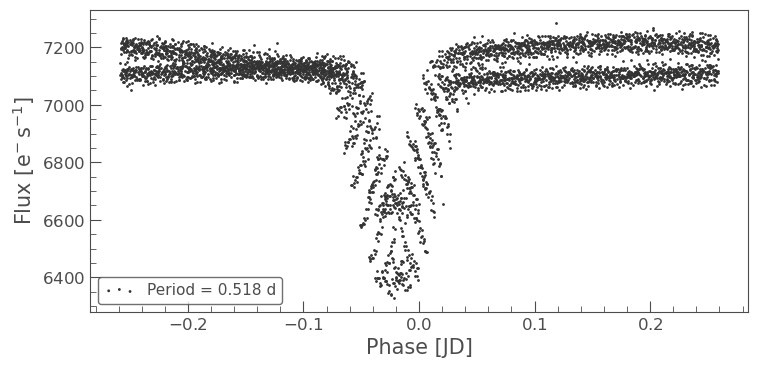

In [9]:
lc.fold(period).scatter(label=f'Period = {period.value:.3f} d');

This doesn't look quite right — it seems like there are two transits of different depths overlapping. The largest peak in the spectrum must be a harmonic of the true period. In fact, what seems to be happening here is that both transits are being interpreted as resulting from the same signal, when in reality the two transits will have slightly different depths and shapes.

Let's try this again, but at double the period value we just measured instead.

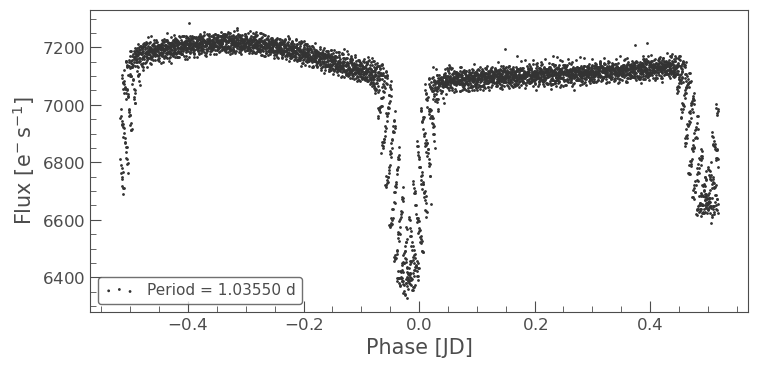

In [10]:
lc.fold(2*period).scatter(label=fr'Period = {2*period.value:.5f} d');

This looks much more sensible! We can see that the two different transits have separated out, and that their differences are clearly visible.

While the precision on the period still has something left to be desired (as there is still a lot of scatter around the transits), it would be fair to say this eclipsing binary pair has an orbital period of roughly one day.

## Exercises

Finding the period of this eclipsing binary is all good and well, but it's not yet very precise, as the [fold()](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.fold.html?highlight=fold) plot indicates. Using keyword arguments of the [to_periodogram()](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.to_periodogram.html?highlight=to_periodogram) function, we can improve this estimate. Try one or both of the following:
- Use the `minimum_period` and `maximum_period` arguments to limit the range of the periodogram to the area around the peak we are interested in.
- Increase the `oversample_factor` argument from the default value of 1, which increases the resolution of the periodogram (this is at the expense of correlating the power values, but that is not a problem for the type of analysis we're doing here).

Tip: you can plot a periodogram in power-period space by using `plot(view='period')`.

In [11]:
#pg = lc.to_periodogram(minimum_period = ..., 
#                       maximum_period = ...,
#                       oversample_factor = ...)

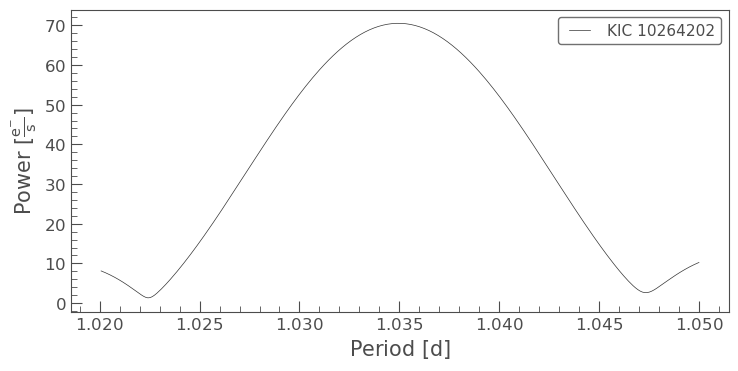

In [12]:
#Solution:
pg = lc.to_periodogram(minimum_period = 1.02, 
                      maximum_period = 1.05,
                      oversample_factor=100)
pg.plot(view='period');

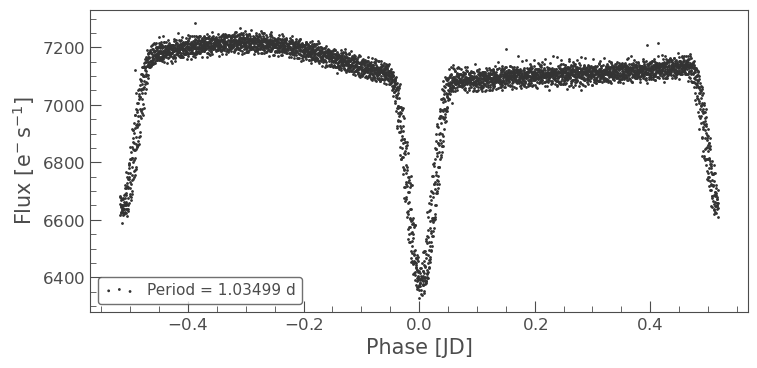

In [13]:
new_period = pg.period_at_max_power
lc.fold(new_period).scatter(label=rf'Period = {new_period.value:.5f} d');

## About this Notebook

**Authors**: Oliver Hall (oliver.hall@esa.int), Geert Barentsen

**Updated On**: 2020-09-15

## Citing Lightkurve and Astropy

If you use `lightkurve` or `astropy` for published research, please cite the authors. Click the buttons below to copy BibTeX entries to your clipboard.

In [14]:
lk.show_citation_instructions()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>
